In [17]:
import math
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import scipy.signal as signal
import skimage.filters as filters
from IPython.display import display, clear_output
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

from PIL import Image
#from pyneurotrace import filters  as pntfilters
from scipy import integrate
from scipy.stats import sem

<H3> Global Variables

In [18]:
# The Folder containing sub-directories to include in analysis
DATA_DIRECTORY = "/home/islandhead/Documents/DBC_Tutoring/Wissam/osfstorage-archive/Data (Images)/"
# Frequency frames were collected
HZ = 10

In [19]:
"""
Jia, H., Rochefort, N. L., Chen, X., & Konnerth, A. (2011).
In vivo two-photon imaging of sensory-evoked dendritic calcium signals in cortical neurons.
Nature protocols, 6(1), 28.
"""
"""
Podgorski, K., & Haas, K. (2013).
Fast non‐negative temporal deconvolution for laser scanning microscopy.
Journal of biophotonics, 6(2), 153-162.
"""
"""
Coleman, P. (2019).
pyNeuroTrace. https://github.com/padster/pyNeuroTrace.git
"""
# To install pyneuortrace use this:
# pip install --upgrade "git+https://github.com/padster/pyNeuroTrace#egg=pyneurotrace&subdirectory=pyneurotrace"

'\nColeman, P. (2019).\npyNeuroTrace. https://github.com/padster/pyNeuroTrace.git\n'

In [20]:
# Change output figure size
# ...needs to be in its own cell for some reason...

plt.rcParams['figure.figsize'] = [20, 5]

In [21]:
"""
Performs fast nonnegative deconvolution on pmt signal to solve for minimum MSE photon rate
   trace  :   The data to be deconvolved
   tau    :   The time constant of the PMT, in data samples
   return :   estimated photon rate
A matlab version is also available on request.
For details on how this works, see:
  Podgorski, K., & Haas, K. (2013).
  Fast non‐negative temporal deconvolution for laser scanning microscopy.
  Journal of biophotonics, 6(2), 153-162.
"""
def nonNegativeDeconvolution(trace, tau):
    T = len(trace)
    counts = np.zeros(T)
    counts[-1] = trace[-1]
    cutoff = math.ceil(8 * tau)
    kernel = np.exp(-np.arange(cutoff + 1)/tau) # convolution kernel
    recent = np.full(1 + round(T / 2), np.nan).astype(int)
    recent[0] = T #stored locations where we assigned counts
    recentIdx = 0

    # the points that could potentially be assigned counts:
    _delayed = np.concatenate(([0], trace[:-2]))
    points = (trace[:-1] > kernel[1] * _delayed) & (trace[:-1] > 0)

    # dividing these points up into runs, for speed
    runStarts = np.where(points & ~(np.concatenate(([False], points[:-1]))))[0].astype(int)
    runEnds = np.where(points & ~(np.concatenate((points[1:], [False]))))[0].astype(int)
    runIdx = len(runEnds) - 1

    while runIdx >= 0:
        oldTop, oldBottom = 0, 0
        t = runEnds[runIdx]
        t1 = t
        accum = 0

        converged = False
        while not converged:
            if recentIdx >= 0 and recent[recentIdx] < (t+cutoff):
                t2 = recent[recentIdx] - 1
                C_max = counts[t2] / kernel[t2-t]
            else:
                t2 = min(t + cutoff, T+1) - 1
                C_max = np.inf


            b = kernel[t1-t:t2-t]
            top = np.dot(b, trace[t1:t2]) + oldTop #this is the numerator of the least squares fit for an exponential
            bottom = np.dot(b, b) + oldBottom #this is the denominator of the fit

            done = False
            while not done:
                #the error function is (data-kernel.*C)^2
                bestC = max(top/bottom, 0);  #C=top/bottom sets the derivative of the error to 0

                # does not meet nonnegative constraint. Continue to adjust previous solutions.
                if bestC > (C_max+accum):
                    accum = accum + counts[t2] / kernel[t2-t]
                    counts[t2] = 0
                    t1 = t2
                    oldTop = top
                    oldBottom = bottom
                    recentIdx -= 1
                    done = True

                else: # converged!
                    #now that we have found the MSE counts for times t<end, check if
                    #this will be swamped by the next timepoint in the run
                    if  (t == runStarts[runIdx]) or (trace[t-1] < bestC/kernel[1]): #%C_max won't necessarily get swamped
                        if recentIdx >= 0 and t2 <= t + cutoff:
                            counts[t2] = counts[t2] - (bestC - accum) * kernel[t2-t]
                        runStart = runStarts[runIdx]
                        initIdx = recentIdx + 1
                        recentIdx = recentIdx + 1 + t - runStart;

                        _skipped = 0
                        if recentIdx + 1 > len(recent):
                            _skipped = recentIdx - (len(recent) - 1)
                            recentIdx = len(recent) - 1


                        recent[initIdx:recentIdx + 1] = np.arange(t+1, runStart + _skipped, -1)
                        counts[runStart:(t+1)] = \
                               np.concatenate((trace[runStart:t], [bestC])) - \
                               np.concatenate(([0], kernel[1]*trace[runStart:t]))
                        done = True
                        converged = True
                    else: #%C_max will get swamped
                        #%in this situation, we know that this point will be removed
                        #%as we continue to process the run. To save time:
                        t -= 1
                        runEnds[runIdx] = t
                        accum = accum / kernel[1]
                        top = top * kernel[1] + trace[t] #% %this is the correct adjustment to the derivative term above
                        bottom = bottom * (kernel[1] ** 2) + 1 #% %this is the correct adjustment to the derivative term above

        runIdx -= 1
    return counts

In [22]:
def nndSmooth(data, hz, tau, iterFunc=None):
    tauSamples = tau * hz

    # This is the transient shape we're deconvolving against:
    # e^(x/tauSamples), for 8 times the length of tau.
    cutoff = round(8 * tauSamples)
    fitted = np.exp(-np.arange(cutoff + 1) / tauSamples)

    def _singleRowNND(samples):
        result = np.copy(samples)
        nanSamples = np.isnan(samples)
        if np.all(nanSamples):
            pass # No data
        elif not np.any(nanSamples):
            # All samples exist, so fit in one go
            result = np.convolve(nonNegativeDeconvolution(samples, tauSamples), fitted)[:len(samples)]
        else:
            # Lots of different runs of samples, fit each separately
            starts = np.where((not nanSamples) & np.isnan(np.concatenate(([1], samples[:-1]))))[0]
            ends = np.where((not nanSamples) & np.isnan(np.concatenate((samples[1:], [1]))))[0]
            for start, end in zip(starts, ends):
                tmp = np.convolve(NND(samples[start:end], tauSamples), fitted)
                result[start:end] = np.max(0, tmp[:end - start + 1])
        return result

    return _forEachTimeseries(data, _singleRowNND, iterFunc)

def deltaFOverF0(data, hz, t0=0.2, t1=0.75, t2=3.0, iterFunc=None):
    t0ratio = None if t0 is None else np.exp(-1 / (t0 * hz))
    t1samples, t2samples = round(t1 * hz), round(t2*hz)

    def _singeRowDeltaFOverF(samples):
        fBar = _windowFunc(np.mean, samples, t1samples, mid=True)
        f0 = _windowFunc(np.min, fBar, t2samples)
        result = (samples - f0) / f0
        if t0ratio is not None:
            result = _ewma(result, t0ratio)
        return result
    return _forEachTimeseries(data, _singeRowDeltaFOverF, iterFunc)


def _windowFunc(f, x, window, mid=False):
    n = len(x)
    startOffset = (window - 1) // 2 if mid else window - 1
    result = np.zeros(x.shape)
    for i in range(n):
        startIdx = i - startOffset
        endIdx = startIdx + window
        startIdx, endIdx = max(0, startIdx), min(endIdx, n)
        result[i] = f(x[startIdx:endIdx])
    return result


def _ewma(x, ratio):
    result = np.zeros(x.shape)
    weightedSum, sumOfWeights = 0.0, 0.0
    for i in range(len(x)):
        weightedSum = ratio * weightedSum + x[i]
        sumOfWeights = ratio * sumOfWeights + 1.0
        result[i] = weightedSum / sumOfWeights
    return result

# Input is either 1d (timeseries), 2d (each row is a timeseries) or 3d (x, y, timeseries)
def _forEachTimeseries(data, func, iterFunc=None):
    if iterFunc is None:
        iterFunc = lambda x: x
    dim = len(data.shape)
    result = np.zeros(data.shape)
    if dim == 1: # single timeseries
        result = func(data)
    elif dim == 2: # (node, timeseries)
        for i in iterFunc(range(data.shape[0])):
            result[i] = func(data[i])
    elif dim == 3: # (x, y, timeseries)
        for i in iterFunc(range(data.shape[0])):
            for j in iterFunc(range(data.shape[1])):
                result[i, j] = func(data[i, j])
    return result

In [300]:
# Take a folder of Tifs and turn it into a numpy array
def folder2tif(dir_path):
    final = []
    files = os.listdir(dir_path)
    files = sorted(files)
    movie = []
    for fname in files:
        im = Image.open(os.path.join(dir_path, fname))
        imarray = np.array(im)
        movie.append(imarray)
    movie = np.asarray(movie)
    return movie

# Returns change in fluorescence over average fluorescence of ROI
def deltaF(video_mask):
    video_mask_nan = video_mask.copy()
    video_mask_nan[video_mask_nan==0] = np.nan
    mean = np.mean(np.nanmean(video_mask))
    print(mean)
    dff= np.zeros((video_mask.shape[0]))
    for i in range(dff.shape[0]):
        delta = np.nanmean(video_mask[i, :, :])-mean
        dff[i] = delta/mean
    return dff

# Returns raw values fluorescence in the ROI
def rawIntensity(video_mask):
    video_mask_nan = video_mask.copy()
    video_mask_nan[video_mask_nan==0] = np.nan
    mean = np.nanmean(video_mask, axis=(1,2))
    return mean

# Generates the ROI 
def genROI(gcamp, rcamp):

    # To create a ROI for the nucleus a STD projection is created
    # Thresholding this image creates a mask for the roi
    std_projectionG = np.std(gcamp, axis=0)
    threshold = filters.threshold_otsu(std_projectionG)
    std_projectionG[std_projectionG < threshold] = 0
    std_projectionG[std_projectionG>0]=1

    # Create a ROI for the cytosl using an STD projection 
    # Thresholding this image creates a mask for the roi
    std_projectionR = np.std(rcamp, axis=0)
    threshold = filters.threshold_otsu(std_projectionR)
    std_projectionR[std_projectionR < threshold] = 0
    std_projectionR[std_projectionR>0]=1
    
    # Remove the Nuclear Mask from this ROI
    std_projectionR[std_projectionG==1]=0
    
    # Applying the masks for the two channels
    gcamp_masked = gcamp * std_projectionG
    rcamp_masked = rcamp * std_projectionR
    
    return gcamp_masked, rcamp_masked


# Generate a ROI for a cell
# Input of data directory, cell, Returns RCaMP and GCamP Raw Inrensity
def Cell2Trace(path, cell):
    # Import the movies provide the path to the folder containing the frames
    gcamp = folder2tif(path+cell+"_G/")
    rcamp = folder2tif(path+cell+"_R/")
    
    # Return Masked Arrays
    gcamp_masked, rcamp_masked = genROI(gcamp, rcamp)
    
    # Return Raw Traces from ROI
    gcamp = rawIntensity(gcamp_masked)
    rcamp = rawIntensity(rcamp_masked)
    
    return gcamp, rcamp

def peakDetect(trace, endpoint):
    # Third Order Butterworth lowpass filter; 3hz cutoff
    
    fc = 3  # Cut-off frequency of the filter
    w = fc / (10 / 2) # Normalize the frequency      
    b, a = signal.butter(3, w, 'low', analog=True)
    z = signal.lfilter(b, a, trace, axis=0)
    
    #plt.plot(trace, linewidth=2, color='Black')
    #plt.plot(z, linewidth=2, color='Red')
    #plt.show()
    
    
    # Detect Peaks
    threshold = np.std(z[:endpoint])

    peaks, _ = signal.find_peaks(trace, width=7, rel_height=.5, prominence=(threshold))

    width = signal.peak_widths(trace, peaks, rel_height=.1)
    
    return peaks, width[0]

def signal_analysis(cell_id, gcamp, rcamp, rawG, rawR):
    print(cell_id)
    str_index = int(cell_id.find("Iono_"))
    threshold_cuttoff = (int(cell_id[(str_index+5):(str_index+8)])*HZ)
    gcamp_peaks, gcamp_widths = peakDetect(gcamp, threshold_cuttoff)
    rcamp_peaks, rcamp_widths = peakDetect(rcamp, threshold_cuttoff)


    drug_app = np.nan
    iono_min = [np.nan, np.nan]
    iono_max = [np.nan, np.nan]
    iono_diff = [np.nan, np.nan]
    
    # Update: Now uses value of drug app from folder name
    # Should return -1 is no match is found for the key string 'Iono_'
    if cell_id.find("Iono_") is not -1:
        str_index = int(cell_id.find("Iono_"))
        drug_app = (int(cell_id[(str_index+5):(str_index+8)])*HZ)
        cutoffG = np.array(np.where(gcamp_peaks >= drug_app)[0])
        if cutoffG.size !=0:
            cutoffG = np.min(cutoffG)
            
        if cutoffG != 0:

            if cutoffG.size !=0:
                cutoffG = np.min(cutoffG)

            cutoffR = np.array(np.where(rcamp_peaks >= drug_app))
            if cutoffR.size !=0:
                cutoffR = np.min(cutoffR)
 
            gcamp_peaks = gcamp_peaks[:cutoffG]
            gcamp_widths = gcamp_widths[:cutoffG]
            rcamp_peaks = rcamp_peaks[:cutoffR]
            rcamp_widths = rcamp_widths[:cutoffR]
    
  
    if cell_id.find("_S") is not -1:
        if drug_app is not np.nan:
            iono_min[0] = np.min(rawG[drug_app-200:drug_app+1000]>0)
            iono_min[1] = np.min(rawR[drug_app-200:drug_app+1000]>0)

            iono_max[0] = np.max(rawG[drug_app-200:drug_app+1000])
            iono_max[1] = np.max(rawR[drug_app-200:drug_app+1000])

            iono_diff[0] = iono_max[0]-iono_min[0]
            iono_diff[1] = iono_max[1]-iono_min[1]

    
    # Match Peaks and puttin them in a list of tuples (g, r)
    gcamp_matched = []
    shared_rcamp = []
    shared_gcamp = []
    for g in gcamp_peaks:
        for r in rcamp_peaks:
            a = math.isclose(g, r, abs_tol=15)
            if a == True:
                gcamp_matched.append((g,r))
                shared_rcamp.append(r)
                shared_gcamp.append(g)
    
    rcamp_only = list(set(rcamp_peaks)-set(shared_rcamp))
    rcamp_only.sort
    gcamp_only = list(set(gcamp_peaks)-set(shared_gcamp))
    gcamp_only.sort

    if len(gcamp_peaks) == 0:
        g_percent_shared = np.nan
    else:
        g_percent_shared = (len(gcamp_matched)/len(gcamp_peaks))
        
    if len(rcamp_peaks) == 0:
        r_percent_shared = np.nan
    else:
        r_percent_shared = (len(gcamp_matched)/len(rcamp_peaks))
    if len(gcamp_matched) == 0:
        r_percent_shared = np.nan
        g_percent_shared = np.nan
        
    # General Stats for the cell
    cell_stats = { 
                                'Cell ID': cell_id,
                                'GCaMP Peaks':len(gcamp_peaks),
                                'RCaMP Peaks':len(rcamp_peaks),
                                'Shared Peaks':len(gcamp_matched),
                                'GCaMP Percent Shared':g_percent_shared,
                                'RCaMP Percent Shared':r_percent_shared,
                                'Experiment Length (s)': gcamp.shape[0]/10,
                                'Drug Application': drug_app/10,
                                'Iono GCaMP Max': iono_max[0],
                                'Iono GCaMP Dif': iono_diff[0],
                                'Iono RCaMP Max': iono_max[1],
                                'Iono RCaMP Dif': iono_diff[1],

                                
                               }
    
    cell_stats = pd.DataFrame(data=cell_stats, index=[0])
    
    # Peak Data for Shared Peaks
    shared_peak_data = pd.DataFrame()
    for event in gcamp_matched:
        
        gindex = np.where(gcamp_peaks == event[0])[0]
        rindex = np.where(rcamp_peaks == event[1])[0]
        
        
        # Integrate Under the Curve for Area 
        # Note: Area from start to peak
        g_event_start = int(event[0]-gcamp_widths[gindex])
        if g_event_start < 0: 
            g_event_start = 0
        r_event_start = int(event[0]-rcamp_widths[rindex])
        if r_event_start < 0:
            r_event_start = 0

        g_area = integrate.cumtrapz(gcamp[g_event_start:event[0]])
        if len(g_area) is not 0:
            g_area = g_area[-1]
        r_area = integrate.cumtrapz(rcamp[r_event_start:event[1]])
        if len(r_area) is not 0:
            r_area = r_area[-1]
        
        peak_stats = {          'Cell ID': cell_id,            
                                'GCaMP Loc':event[0],
                                'GCaMP Start': event[0]-gcamp_widths[gindex][0]*HZ,
                                'GCaMP Width':gcamp_widths[gindex][0],
                                'GCaMP Prominence':gcamp[event[0]],
                                'GCaMP Area':g_area,                                
                                'RCaMP Loc':event[1],
                                'RCaMP Start': event[1]-rcamp_widths[rindex][0]*HZ,
                                'RCaMP Width':rcamp_widths[rindex][0],
                                'RCaMP Prominence':rcamp[event[1]],
                                'RCaMP Area':r_area,                                
                                'Promicence Ratio (G/R)':(gcamp[event[1]]/rcamp[event[0]]),
                                'Peak Time Diff (G-R)':((event[0]-event[1])*100),
                                'Start Difference (G-R)': (event[0]-gcamp_widths[gindex] - event[1]-rcamp_widths[rindex])[0]*100  
                                                                 }
        shared_peak_data = shared_peak_data.append(peak_stats, ignore_index=True)
    
    # Adding RCaMP peaks to the shared datatable
    for event in rcamp_only:
        
        rindex = np.where(rcamp_peaks == event)[0]
        
        
        # Integrate Under the Curve for Area 
        # Note: Area from start to peak
        r_event_start = int(event-rcamp_widths[rindex])
        if r_event_start < 0:
            r_event_start = 0

        r_area = integrate.cumtrapz(rcamp[r_event_start:event])
        if len(r_area) is not 0:
            r_area = r_area[-1]
        
        peak_stats = {          'Cell ID': cell_id,            
                                'GCaMP Loc':np.nan,
                                'GCaMP Start': np.nan,
                                'GCaMP Width':np.nan,
                                'GCaMP Prominence':np.nan,
                                'GCaMP Area':np.nan,                                
                                'RCaMP Loc':event,
                                'RCaMP Start': event-rcamp_widths[rindex][0]*HZ,
                                'RCaMP Width':rcamp_widths[rindex][0],
                                'RCaMP Prominence':rcamp[event],
                                'RCaMP Area':r_area,                                
                                'Promicence Ratio (G/R)':0,
                                'Peak Time Diff (G-R)':np.nan,
                                'Start Difference (G-R)': np.nan,  
                                                                 }
        shared_peak_data = shared_peak_data.append(peak_stats, ignore_index=True)
    
    
    
    # Peak Data for exclusive GCaMP Peaks
    gcamp_peak_data = pd.DataFrame()
    for event in gcamp_only:
        gindex = np.where(gcamp_peaks == event)[0]

        # Integrate Under the Curve for Area 
        # Note: Area from start to peak
        g_event_start = int(event-gcamp_widths[gindex])
        if g_event_start < 0:
            g_event_start = 0

        g_area = integrate.cumtrapz(gcamp[g_event_start:event])
        if len(g_area) is not 0:
            g_area = g_area[-1]
        
        peak_stats = {          'Cell ID': cell_id,            
                                'GCaMP Loc':event,
                                'GCaMP Start': event-gcamp_widths[gindex][0]*HZ,
                                'GCaMP Width':gcamp_widths[gindex][0],
                                'GCaMP Prominence':gcamp[event],
                                'GCaMP Area':g_area,
                                                         }
                                                         
        gcamp_peak_data = gcamp_peak_data.append(peak_stats, ignore_index=True) 
        
    # Peak Data for exclusive RCaMP Peaks
    rcamp_peak_data = pd.DataFrame()
                                                         
    for event in rcamp_only:
        rindex = np.where(rcamp_peaks == event)[0]
        # Integrate Under the Curve for Area 
        # Note: Area from start to peak
        r_event_start = int(event-rcamp_widths[rindex])
        if r_event_start < 0:
            r_event_start = 0

        r_area = integrate.cumtrapz(rcamp[r_event_start:event])
        if len(r_area) is not 0:
            r_area = r_area[-1]
        
        peak_stats = {          'Cell ID': cell_id,            
                                'RCaMP Loc':event,
                                'RCaMP Start': (event-rcamp_widths[rindex][0])*HZ,
                                'RCaMP Width':rcamp_widths[rindex][0],
                                'RCaMP Prominence':rcamp[event],
                                'RCaMP Area':r_area, 

                                                                 }
        rcamp_peak_data = rcamp_peak_data.append(peak_stats, ignore_index=True) 
        
        
        cell_stats["Prominence Ratio Mean"] = np.nanmean(np.array(shared_peak_data["Promicence Ratio (G/R)"]))
        cell_stats["Prominence Ratio SEM"] = sem(np.array(shared_peak_data["Promicence Ratio (G/R)"]))
        
    return cell_stats, shared_peak_data, gcamp_peak_data, rcamp_peak_data
    
    
    

In [296]:
def results(cell, RTrace, GTrace, Rdff, Gdff ):
    plt.rcParams["figure.figsize"] = [16, 10]


    fig, ax = plt.subplots(2)
    ax[0].plot(RTrace.loc[cell][1], linewidth=1, color='Red')
    ax[1].plot(Rdff.loc[cell][1], linewidth=1, color='Red')
    ax[0].plot(GTrace.loc[cell][1], linewidth=1, color='Green')
    ax[1].plot(Gdff.loc[cell][1], linewidth=1, color='Green')
    ax[0].set_ylabel('Raw Intensity')
    ax[1].set_ylabel(' ΔF/F ')

    plt.show()



In [297]:
# Collects all the cells in the analysis data directory and groups
# Them by condition in two lists
path = os.fspath(DATA_DIRECTORY)
cells = sorted((os.listdir(path)))
WT_Cells = []
YAC128_Cells = []
for folder in cells:
    print(folder)
    if 'WT'  in folder:
        WT_Cells.append(folder[:-2])
    if 'YAC128'  in folder:
        YAC128_Cells.append(folder[:-2])
        
WT_Cells = np.unique(WT_Cells)
YAC128_Cells = np.unique(YAC128_Cells)


Cell 14_YAC128_Iono_270_S_G
Cell 14_YAC128_Iono_270_S_R
Cell 17_WT_Iono_180_S_G
Cell 17_WT_Iono_180_S_R
Cell 18_WT_Iono_180_S_G
Cell 18_WT_Iono_180_S_R
Cell 22_YAC128_Iono_180_D_G
Cell 22_YAC128_Iono_180_D_R
Cell 29_YAC128_Iono_180_D_G
Cell 29_YAC128_Iono_180_D_R
Cell 46_YAC128_Iono_060_S_G
Cell 46_YAC128_Iono_060_S_R
Cell 47_YAC128_Iono_180_S_G
Cell 47_YAC128_Iono_180_S_R
Cell 48_YAC128_Iono_088_S_G
Cell 48_YAC128_Iono_088_S_R
Cell 49_YAC128_Iono_155_S_G
Cell 49_YAC128_Iono_155_S_R


# <h> Cycle Through WT Cells to Extract Peak Data

Cell 17_WT_Iono_180_S


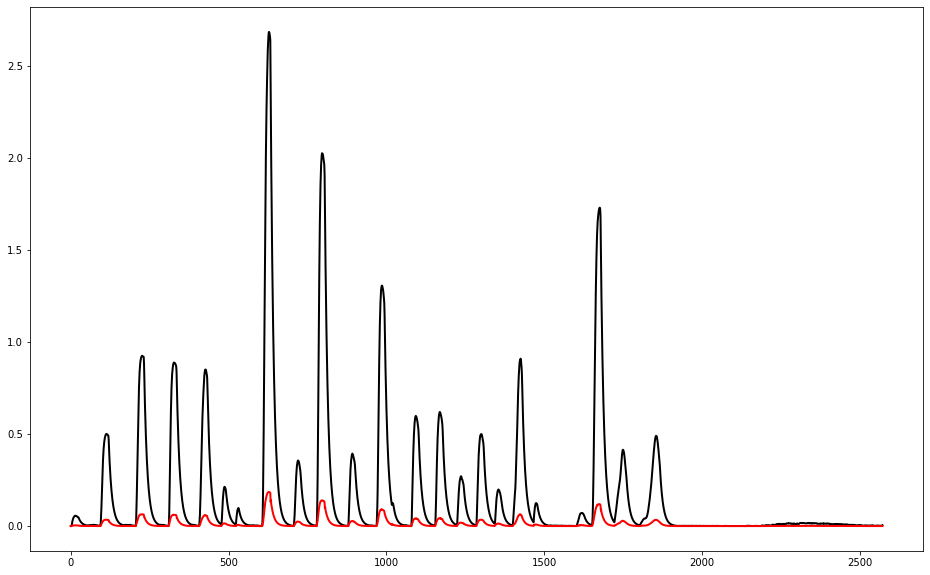

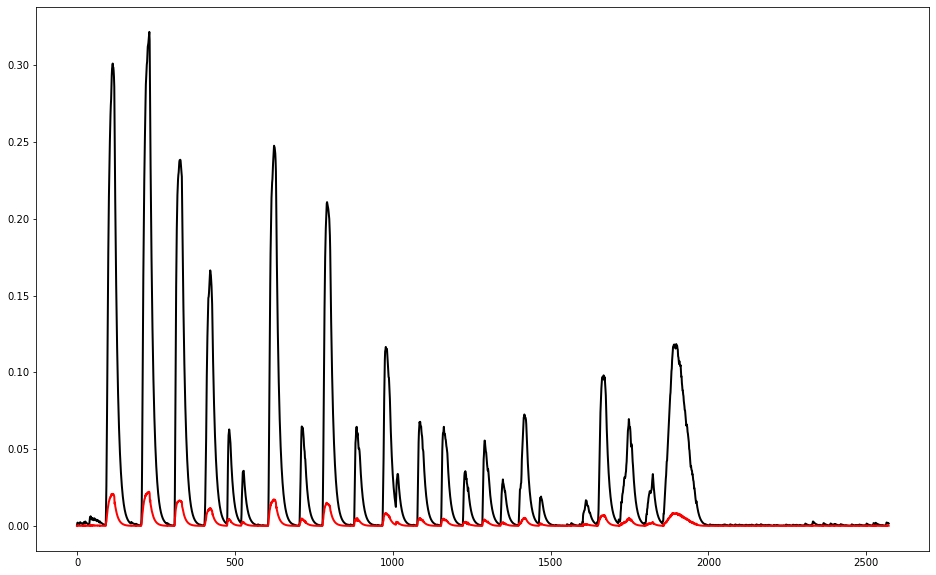

Cell 18_WT_Iono_180_S


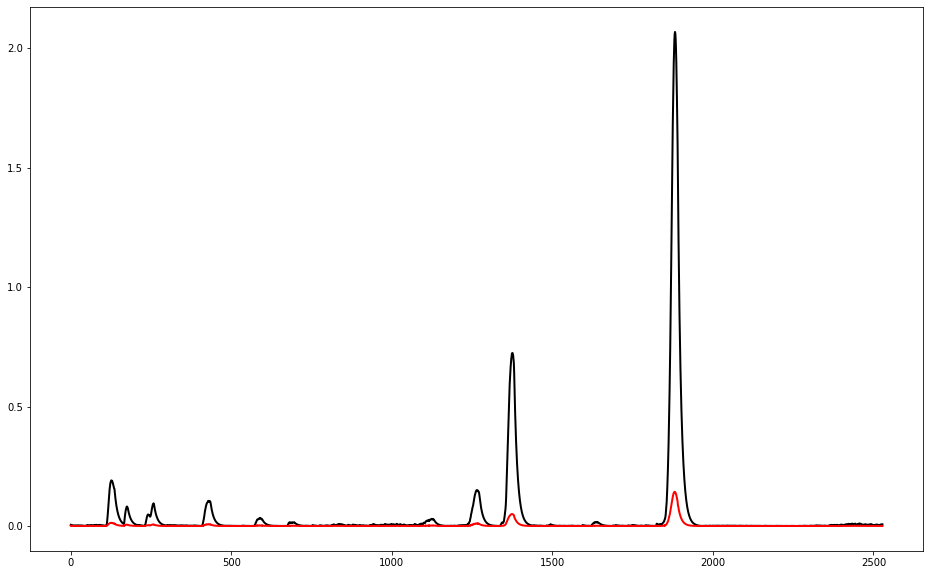

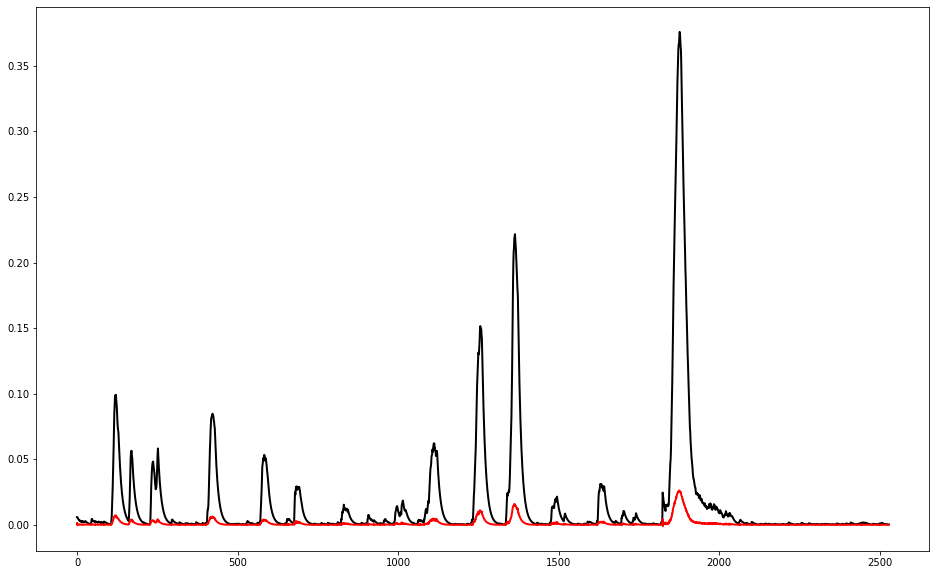

In [298]:
WT_Stats = pd.DataFrame()
WT_Shared_Peaks = pd.DataFrame()
WT_GCaMP = pd.DataFrame()
WT_RCaMP = pd.DataFrame()

WT_GTrace = pd.DataFrame()
WT_RTrace = pd.DataFrame()

WT_GDFF = pd.DataFrame()
WT_RDFF = pd.DataFrame()

for cell in WT_Cells:
    gcamp, rcamp = Cell2Trace(path, cell)
    
    WT_RTrace = WT_RTrace.append(pd.Series([cell, rcamp], name=cell))
    WT_GTrace = WT_GTrace.append(pd.Series([cell, gcamp], name=cell))   
        
    # Calculate df/f and perform NND
    dffG = deltaFOverF0(gcamp, HZ)
    dffG = nndSmooth(dffG, HZ, tau=1)
    dffR = deltaFOverF0(rcamp, HZ)
    dffR = nndSmooth(dffR, HZ, tau=1)
    
    
    
    WT_RDFF = WT_RDFF.append(pd.Series([cell, dffR], name=cell))
    WT_GDFF = WT_GDFF.append(pd.Series([cell, dffG], name=cell))
    
    cell_stats, peak_data, gcamp_peak_data, rcamp_peak_data= signal_analysis(cell, dffG, dffR, gcamp, rcamp)
    
    WT_Stats = WT_Stats.append(cell_stats, ignore_index=True)
    WT_Shared_Peaks = WT_Shared_Peaks.append(peak_data, ignore_index=True)
    WT_GCaMP = WT_GCaMP.append(gcamp_peak_data, ignore_index=True)
    WT_RCaMP = WT_RCaMP.append(rcamp_peak_data, ignore_index=True)



# <h2> Save Results for WT to CSV

In [175]:
np.set_printoptions(threshold=8000)
WT_Stats.to_csv("WT_Stats.csv", index=False)
WT_Shared_Peaks.to_csv("WT_Shared_Peaks.csv", index=False)
WT_GCaMP.to_csv("WT_GCaMP.csv", index=False)
WT_RCaMP.to_csv("WT_RCaMP.csv", index=False)

WT_RTrace.to_csv("WT_R_Trace.csv", index=False)
WT_GTrace.to_csv("WT_G_Trace.csv", index=False)
WT_RDFF.to_csv("WT_R_DFF.csv", index=False)
WT_GDFF.to_csv("WT_G_DFF.csv", index=False)

np.set_printoptions(threshold=10)

# <h2> Display Results for WT

In [299]:
display(WT_Stats)
display(WT_Shared_Peaks)
display(WT_GCaMP)
display(WT_RCaMP)

,Cell ID,GCaMP Peaks,RCaMP Peaks,Shared Peaks,GCaMP Percent Shared,RCaMP Percent Shared,Experiment Length (s),Drug Application,Iono GCaMP Max,Iono GCaMP Dif,Iono RCaMP Max,Iono RCaMP Dif,Prominence Ratio Mean,Prominence Ratio SEM
0,Cell 17_WT_Iono_180_S,22,23,21,0.954545,0.913043,257.2,180.0,30.786286,29.786286,19.248580,18.248580,6.539606,0.906572
1,Cell 18_WT_Iono_180_S,12,24,12,1.000000,0.500000,252.9,180.0,29.194602,28.194602,18.144112,17.144112,0.606350,0.186809


,Cell ID,GCaMP Area,GCaMP Loc,GCaMP Prominence,GCaMP Start,GCaMP Width,Peak Time Diff (G-R),Promicence Ratio (G/R),RCaMP Area,RCaMP Loc,RCaMP Prominence,RCaMP Start,RCaMP Width,Start Difference (G-R)
0,Cell 17_WT_Iono_180_S,5.923661,114.0,0.500777,-34.681136,14.868114,100.0,1.675790,2.93325,113.0,0.301117,-7.162804,12.016280,-2588.439404
1,Cell 17_WT_Iono_180_S,10.700284,226.0,0.925305,78.817853,14.718215,-300.0,2.931590,4.35158,229.0,0.321727,104.949633,12.405037,-3012.325136
2,Cell 17_WT_Iono_180_S,9.038640,327.0,0.888553,174.696257,15.230374,0.0,3.726077,2.85684,327.0,0.238469,177.785537,14.921446,-3015.182061
3,Cell 17_WT_Iono_180_S,7.861098,427.0,0.850693,312.777324,11.422268,500.0,5.256002,0.624492,422.0,0.166401,323.362773,9.863723,-1628.599028
4,Cell 17_WT_Iono_180_S,0.989594,487.0,0.213380,417.191274,6.980873,500.0,3.084750,[],482.0,0.062836,430.648524,5.135148,-711.602026
5,Cell 17_WT_Iono_180_S,0.333205,531.0,0.098373,489.779800,4.122020,300.0,3.236305,0.0356587,528.0,0.035897,483.340063,4.465994,-558.801366
6,Cell 17_WT_Iono_180_S,25.630367,628.0,2.685433,515.289749,11.271025,400.0,10.658677,1.81228,624.0,0.247598,498.868619,12.513138,-1978.416315
7,Cell 17_WT_Iono_180_S,2.374539,720.0,0.356550,625.894504,9.410550,800.0,3.846753,[],712.0,0.064776,643.089121,6.891088,-830.163751
8,Cell 17_WT_Iono_180_S,18.317881,796.0,2.026235,658.036284,13.796372,400.0,9.296942,1.53366,792.0,0.210882,658.758392,13.324161,-2312.053243
9,Cell 17_WT_Iono_180_S,2.793131,892.0,0.393930,789.364810,10.263519,600.0,6.096185,[],886.0,0.064551,822.218696,6.378130,-1064.164946


,Cell ID,GCaMP Area,GCaMP Loc,GCaMP Prominence,GCaMP Start,GCaMP Width
0,Cell 17_WT_Iono_180_S,0.433981,15.0,0.056678,-90.342456,10.534246


,Cell ID,RCaMP Area,RCaMP Loc,RCaMP Prominence,RCaMP Start,RCaMP Width
0,Cell 17_WT_Iono_180_S,0.0909081,1016.0,0.033893,10127.514319,3.248568
1,Cell 17_WT_Iono_180_S,0.00527687,43.0,0.006284,415.659639,1.434036
2,Cell 18_WT_Iono_180_S,0.0034215,960.0,0.004463,9580.283785,1.971622
3,Cell 18_WT_Iono_180_S,0.0132021,997.0,0.014367,9958.475601,1.152440
4,Cell 18_WT_Iono_180_S,0.0222388,1702.0,0.010565,16985.214657,3.478534
5,Cell 18_WT_Iono_180_S,[],1064.0,0.003845,10632.951787,0.704821
6,Cell 18_WT_Iono_180_S,0.00585606,297.0,0.003976,2947.749393,2.225061
7,Cell 18_WT_Iono_180_S,0.0105065,908.0,0.007559,9058.299850,2.170015
8,Cell 18_WT_Iono_180_S,0.00609231,1741.0,0.008872,17396.844853,1.315515
9,Cell 18_WT_Iono_180_S,0.00206008,46.0,0.004591,447.118637,1.288136


# <h2> Inspect Results

Dropdown(description='WT Cells:', index=1, options=('Cell 17_WT_Iono_180_S', 'Cell 18_WT_Iono_180_S'), value='…

Cell 18_WT_Iono_180_S


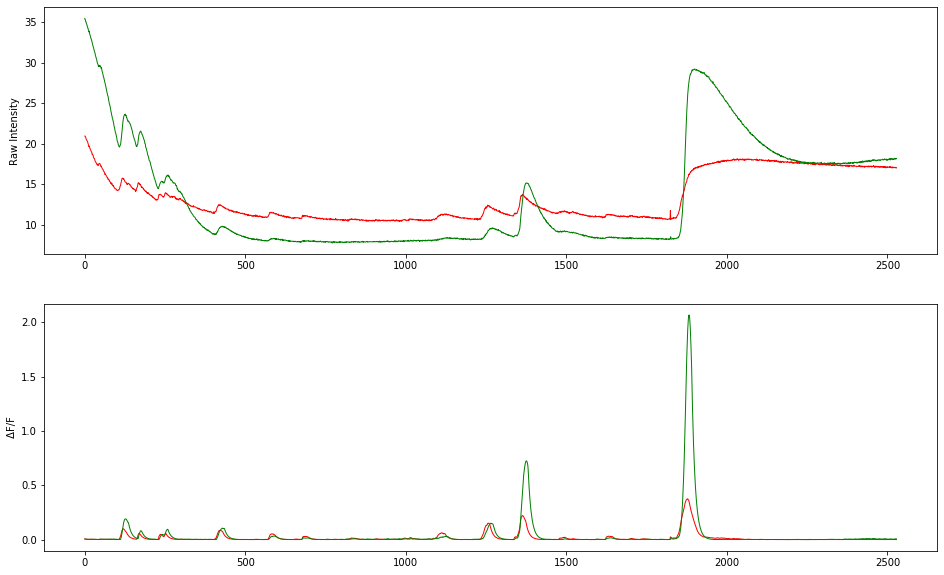

In [254]:
SelectWTCells = widgets.Dropdown(
    options=WT_Cells,
    value=WT_Cells[0],
    description='WT Cells:',
    disabled=False,
)
def on_change(change, results=results):
    if change['name'] == 'value' and (change['new'] != change['old']):
        clear_output()
        display(SelectWTCells)
        print(change['new'])
        results(change['new'], WT_RTrace, WT_GTrace, WT_RDFF, WT_GDFF)
     
        
display(SelectWTCells)
results(WT_Cells[0], WT_RTrace, WT_GTrace, WT_RDFF, WT_GDFF)
SelectWTCells.observe(on_change)

# <h> Cycle Through YAC128 Cells to Extract Peak Data

In [ ]:
YAC128_Stats = pd.DataFrame()
YAC128_Shared_Peaks = pd.DataFrame()
YAC128_GCaMP = pd.DataFrame()
YAC128_RCaMP = pd.DataFrame()

YAC128_GTrace = pd.DataFrame()
YAC128_RTrace = pd.DataFrame()

YAC128_GDFF = pd.DataFrame()
YAC128_RDFF = pd.DataFrame()
for cell in YAC128_Cells:
    gcamp, rcamp = Cell2Trace(path, cell)
    
    YAC128_RTrace = YAC128_RTrace.append(pd.Series([cell, rcamp], name=cell))
    YAC128_GTrace = YAC128_GTrace.append(pd.Series([cell, gcamp], name=cell))   
        

    # Calculate df/f and perform NND
    dffG = deltaFOverF0(gcamp, HZ)
    dffG = nndSmooth(dffG, HZ, tau=1)
    dffR = deltaFOverF0(rcamp, HZ)
    dffR = nndSmooth(dffR, HZ, tau=1)
    
    
    YAC128_RDFF = YAC128_RDFF.append(pd.Series([cell, dffR], name=cell))
    YAC128_GDFF = YAC128_GDFF.append(pd.Series([cell, dffG], name=cell))
    
    
    cell_stats, peak_data, gcamp_peak_data, rcamp_peak_data = signal_analysis(cell, dffG, dffR, gcamp, rcamp)
    
    
    YAC128_Stats = YAC128_Stats.append(cell_stats, ignore_index=True)
    YAC128_Shared_Peaks = YAC128_Shared_Peaks.append(peak_data, ignore_index=True)
    YAC128_GCaMP = YAC128_GCaMP.append(gcamp_peak_data, ignore_index=True)
    YAC128_RCaMP = YAC128_RCaMP.append(rcamp_peak_data, ignore_index=True)


# <h2> Save Results for YAC128 to CSV

In [ ]:
np.set_printoptions(threshold=8000)
YAC128_Stats.to_csv("YAC128_Stats.csv", index=False)
YAC128_Shared_Peaks.to_csv("YAC128_Shared_Peaks.csv", index=False)
YAC128_GCaMP.to_csv("YAC128_GCaMP.csv", index=False)
YAC128_RCaMP.to_csv("YAC128_RCaMP.csv", index=False)

YAC128_RTrace.to_csv("YAC128_R_Trace.csv", index=False)
YAC128_GTrace.to_csv("YAC128_G_Trace.csv", index=False)
YAC128_RDFF.to_csv("YAC128_R_DFF.csv", index=False)
YAC128_GDFF.to_csv("YAC128_G_DFF.csv", index=False)

np.set_printoptions(threshold=10)

# <h2> Display Results for YAC128

In [ ]:
display(YAC128_Stats)
display(YAC128_Shared_Peaks)
display(YAC128_GCaMP)
display(YAC128_RCaMP)


# <h2> Inspect Results

In [ ]:
SelectYAC128Cells = widgets.Dropdown(
    options=YAC128_Cells,
    value=YAC128_Cells[0],
    description='YAC128 Cell:',
    disabled=False,
)
def on_change(change, results=results):
    if change['name'] == 'value' and (change['new'] != change['old']):
        clear_output()
        display(SelectYAC128Cells)
        print(change['new'])
        results(change['new'], YAC128_RTrace, YAC128_GTrace, YAC128_RDFF, YAC128_GDFF)
     
        
display(SelectYAC128Cells)
results(YAC128_Cells[0], YAC128_RTrace, YAC128_GTrace, YAC128_RDFF, YAC128_GDFF)
SelectYAC128Cells.observe(on_change)